In [ ]:
!pip install pillow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler


## Dataset Loading and Preprocessing


In [ ]:
data_dir = '/content/drive/MyDrive/Likhita Project/Dataset'

In [ ]:
df = pd.read_csv('/content/Annotations.csv')
df

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,car,0,1434,2306,2369,IMG_8282.JPG,3024,4032
1,car,2134,1186,890,272,IMG_8282.JPG,3024,4032
2,sign board,464,1016,300,113,IMG_8282.JPG,3024,4032
3,car,0,1316,2893,2084,IMG_8283.JPG,3024,4032
4,sign board,2139,896,370,142,IMG_8283.JPG,3024,4032
...,...,...,...,...,...,...,...,...
156,car,6,352,4016,1755,IMG_8436.JPG,4032,3024
157,sign board,561,36,2091,2311,IMG_8437.JPG,3024,4032
158,car,44,608,3988,1952,IMG_8438.JPG,4032,3024
159,car,300,1211,3040,1488,IMG_8439.JPG,4032,3024


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label_name    161 non-null    object
 1   bbox_x        161 non-null    int64 
 2   bbox_y        161 non-null    int64 
 3   bbox_width    161 non-null    int64 
 4   bbox_height   161 non-null    int64 
 5   image_name    161 non-null    object
 6   image_width   161 non-null    int64 
 7   image_height  161 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 10.2+ KB


In [ ]:
df['image_id'] = df['image_name'].apply(lambda x: x[0:-4])
df['label_id'] = df['label_name'].apply(lambda x: 0 if x == 'car' else 1)
df

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height,image_id,label_id
0,car,0,1434,2306,2369,IMG_8282.JPG,3024,4032,IMG_8282,0
1,car,2134,1186,890,272,IMG_8282.JPG,3024,4032,IMG_8282,0
2,sign board,464,1016,300,113,IMG_8282.JPG,3024,4032,IMG_8282,1
3,car,0,1316,2893,2084,IMG_8283.JPG,3024,4032,IMG_8283,0
4,sign board,2139,896,370,142,IMG_8283.JPG,3024,4032,IMG_8283,1
...,...,...,...,...,...,...,...,...,...,...
156,car,6,352,4016,1755,IMG_8436.JPG,4032,3024,IMG_8436,0
157,sign board,561,36,2091,2311,IMG_8437.JPG,3024,4032,IMG_8437,1
158,car,44,608,3988,1952,IMG_8438.JPG,4032,3024,IMG_8438,0
159,car,300,1211,3040,1488,IMG_8439.JPG,4032,3024,IMG_8439,0


In [ ]:
BATCH_SIZE = 4
TRAIN_SPLIT = 0.8 # 80%-20% train test split
VAL_SPLIT = 0.5 # 10% - 10% split for validaion snd test

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
label = df.loc[df['image_name']=='IMG_8437.JPG']['label_name']
label.values[0]

'sign board'

In [ ]:
from math import e
class Dataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, root, transforms):
    self.root = root
    self.transforms = transforms
    self.df = csv_file
    self.imgs = list(os.listdir(root))

  def __getitem__(self,idx):

    img_path = os.path.join(self.root,self.imgs[idx])
    #print(img_path)
    row = self.df.loc[self.df['image_name']==self.imgs[idx]]
    img = Image.open(img_path).convert("RGB")
    name = self.imgs[idx]

    if self.transforms:
      img = self.transforms(img)
    
    return img,name

  def __len__(self):
    return len(self.imgs)

## Mask generation


In [ ]:
masked_images = {
}

labels = {
    
}
img_path = data_dir + '/'

for i,row in df.iterrows():
  #image = Image.open(img_path+row['image_name'])
  w,h = row['image_width'], row['image_height']
  mask = Image.new('RGB',(int(row['image_width']),int(row['image_height'])))
  draw = ImageDraw.Draw(mask)
  x_center, y_center, box_width, box_height = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']

  # Convert YOLO coordinates to pixel coordinates
  xmin = x_center
  ymin = y_center
  xmax = x_center + box_width
  ymax = y_center + box_height

  outline = 'red' if row['label_id'] == 0 else 'blue'

  draw.rectangle([xmin, ymin, xmax, ymax], outline=outline, fill=outline)

  masked_images[row['image_name']] = mask
  labels[row['image_name']] = row['label_name']




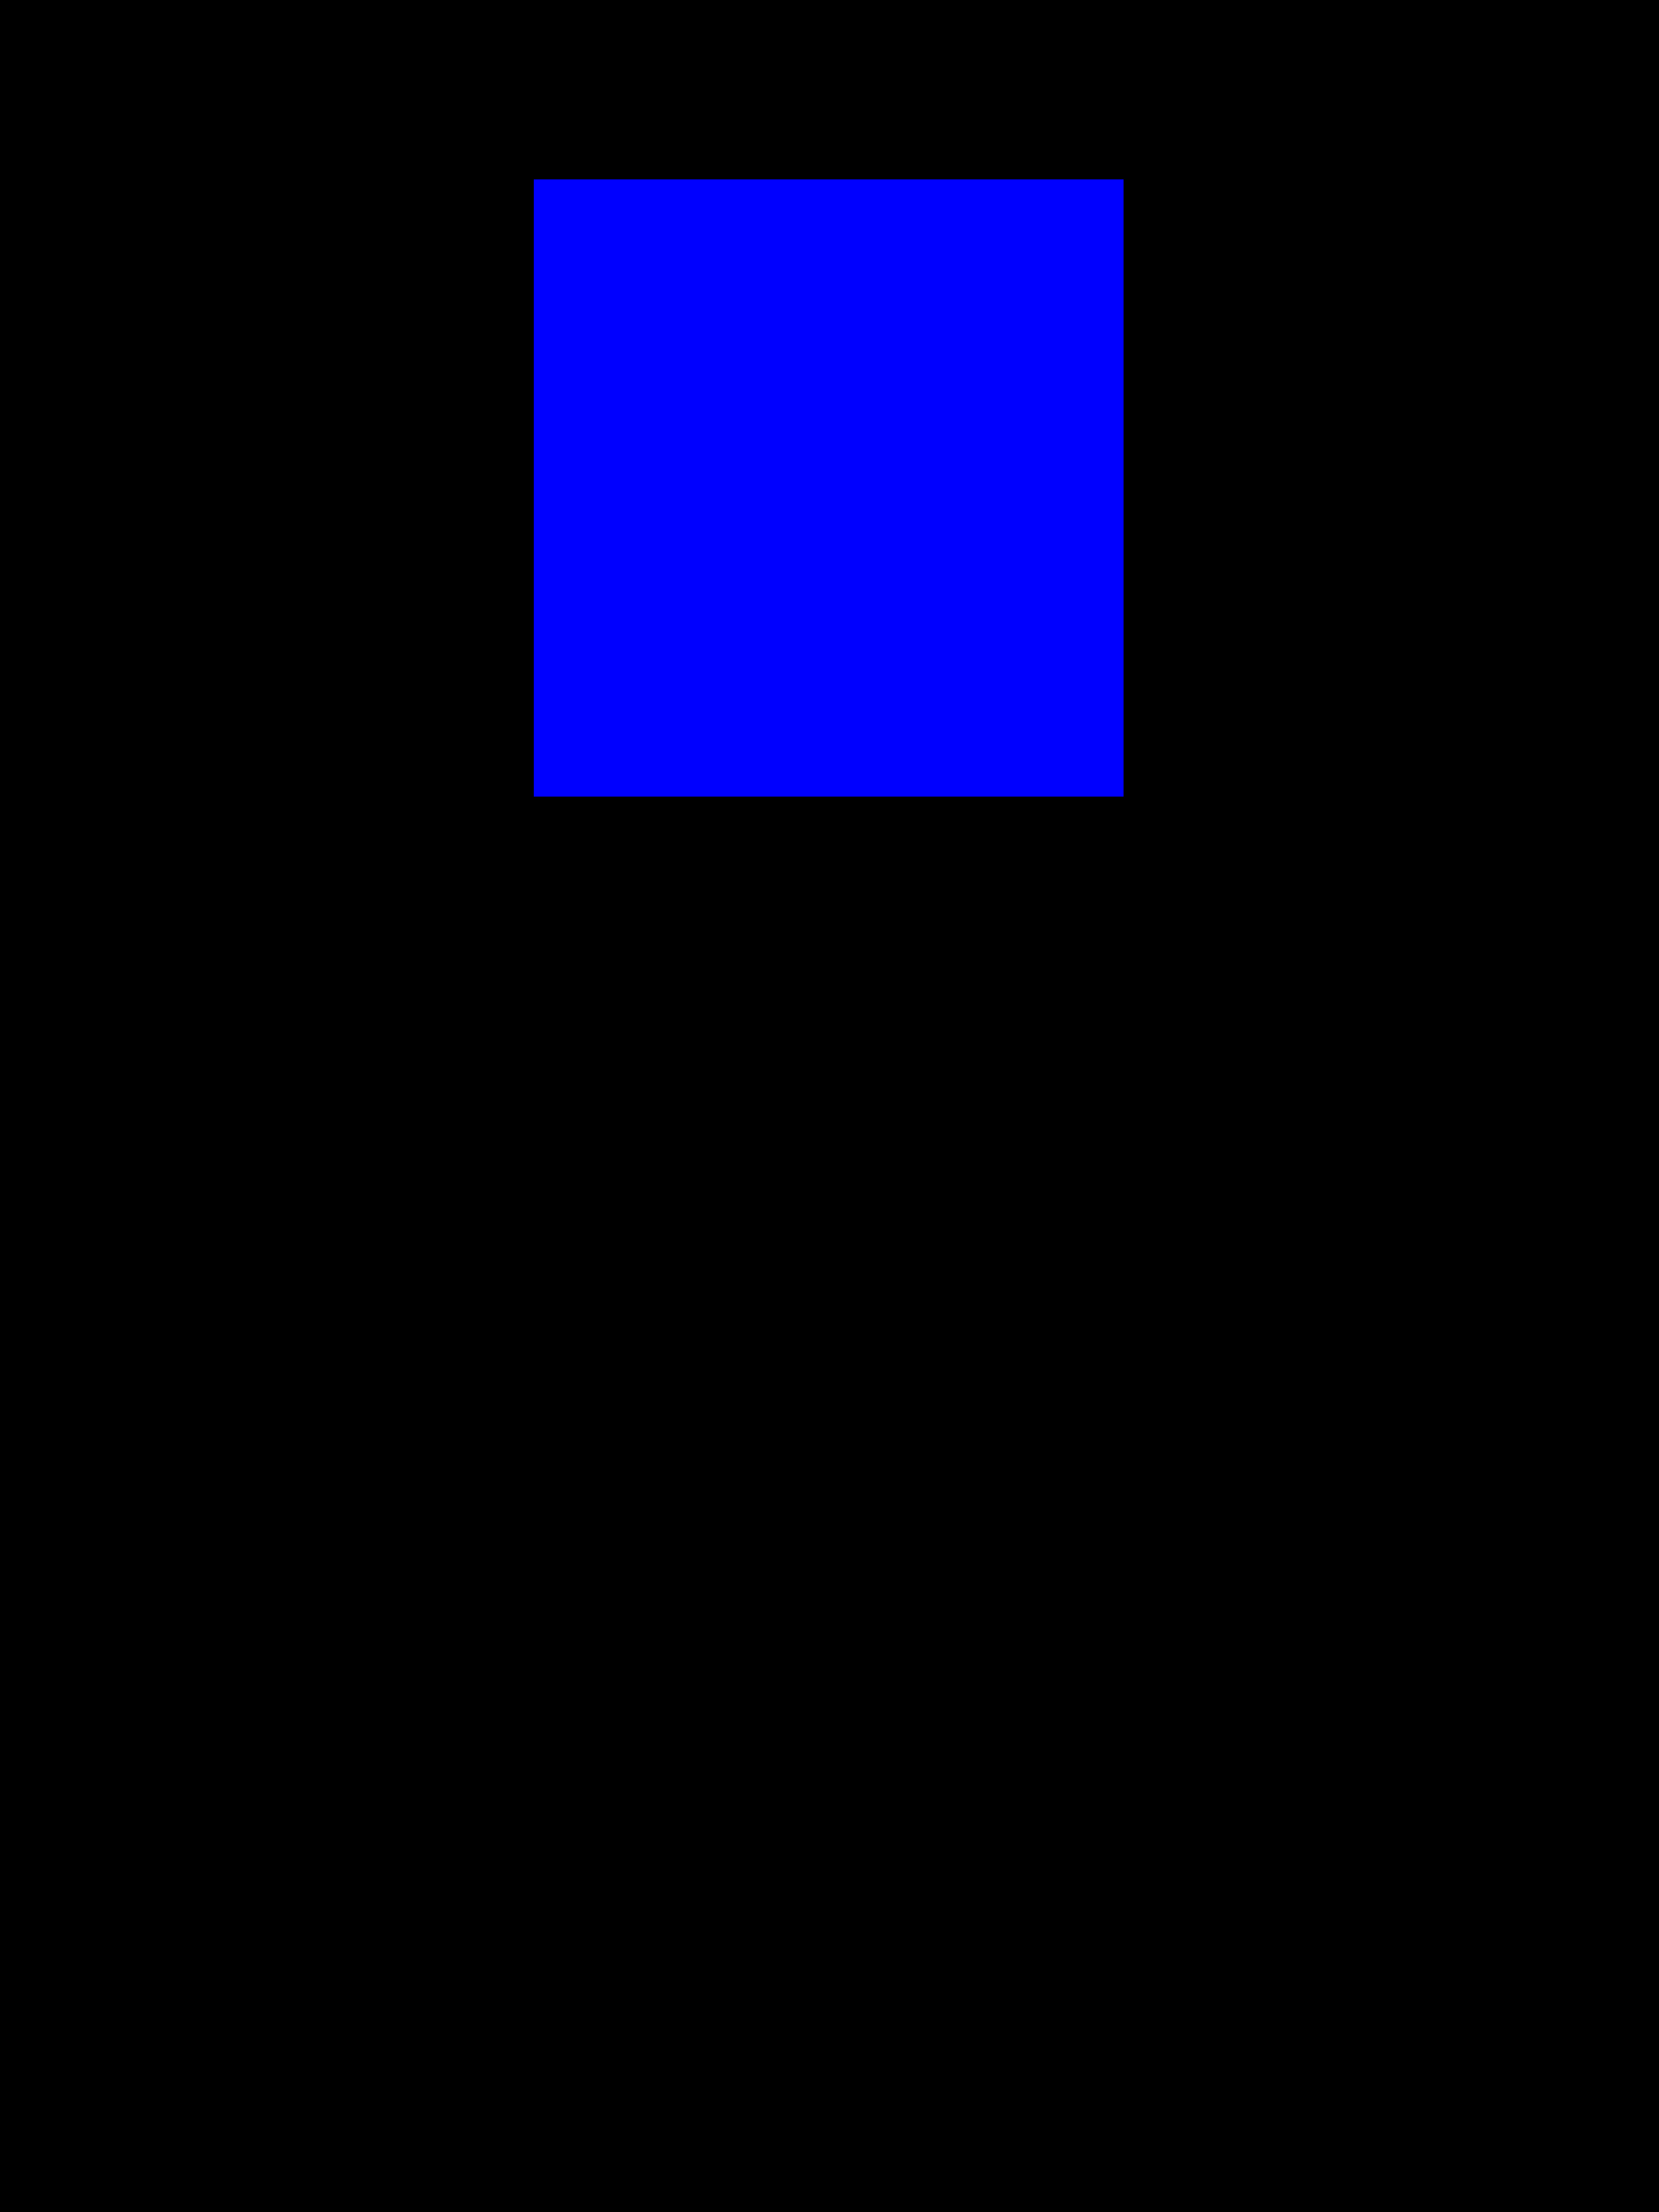

In [ ]:
masked_images['IMG_8374.JPG'].show()

In [ ]:
labels['IMG_8374.JPG']

'sign board'

In [ ]:
r  = df.loc[df['image_name'] == 'IMG_8368.JPG']
print(r['label_id'].values[0] == 1)
outline = 'red' if r['label_id'].values[0] == 0 else 'blue'
outline

True


'blue'

## Train Test Val split


In [ ]:
img_data = Dataset(root=data_dir, csv_file=df, transforms=transform)
indices = list(range(len(img_data)))
s1 = int(np.floor(VAL_SPLIT * len(img_data)))
s2 = int(np.floor(TRAIN_SPLIT*len(img_data)))

train_indx = indices[:s1]
val_indx = indices[s1:s1+s2]
test_index = indices[s1+s2:]

train_sampler = SubsetRandomSampler(train_indx)
val_sampler = SubsetRandomSampler(val_indx)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(img_data, batch_size = BATCH_SIZE, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(img_data, batch_size = BATCH_SIZE, sampler=val_sampler, shuffle=False)
test_loader = DataLoader(img_data, batch_size = BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Visualisation


Original Images


In [ ]:

t_i = []
t_m = []
t_l = []
for i, (imgs,names) in enumerate(train_loader):
  t = transforms.ToPILImage()
  img = t(imgs[0])
  print(names[0])
  t_i.append(img)
  t_m.append(masked_images[names[0]])
  t_l.append(names[0])


IMG_8370.JPG
IMG_8408.JPG
IMG_8356.JPG
IMG_8345.JPG
IMG_8339.JPG
IMG_8359.JPG
IMG_8410.JPG
IMG_8400.JPG
IMG_8385.JPG
IMG_8378.JPG


RuntimeError: ignored

In [ ]:
len(t_l)

10

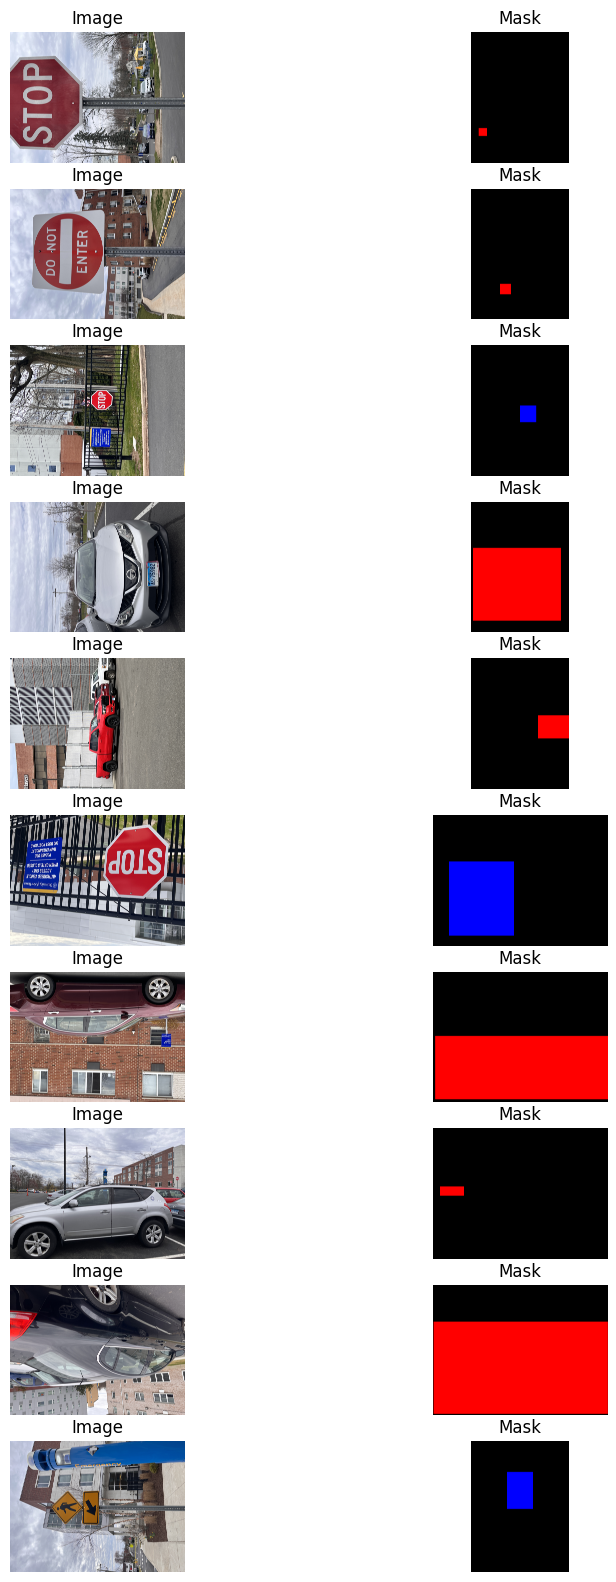

In [ ]:
import matplotlib.pyplot as plt

# assuming you have two lists: images and masks
num_images = len(t_i)

fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 20))

for i in range(num_images):
    # display the image in the left subplot
    axes[i, 0].imshow(t_i[i])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    
    # display the mask in the right subplot
    axes[i, 1].imshow(t_m[i])
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

plt.show()


Maked Images (input) and Labesl

In [ ]:
fig = plt.figure(figsize=(12,12))

In [ ]:
import itertools

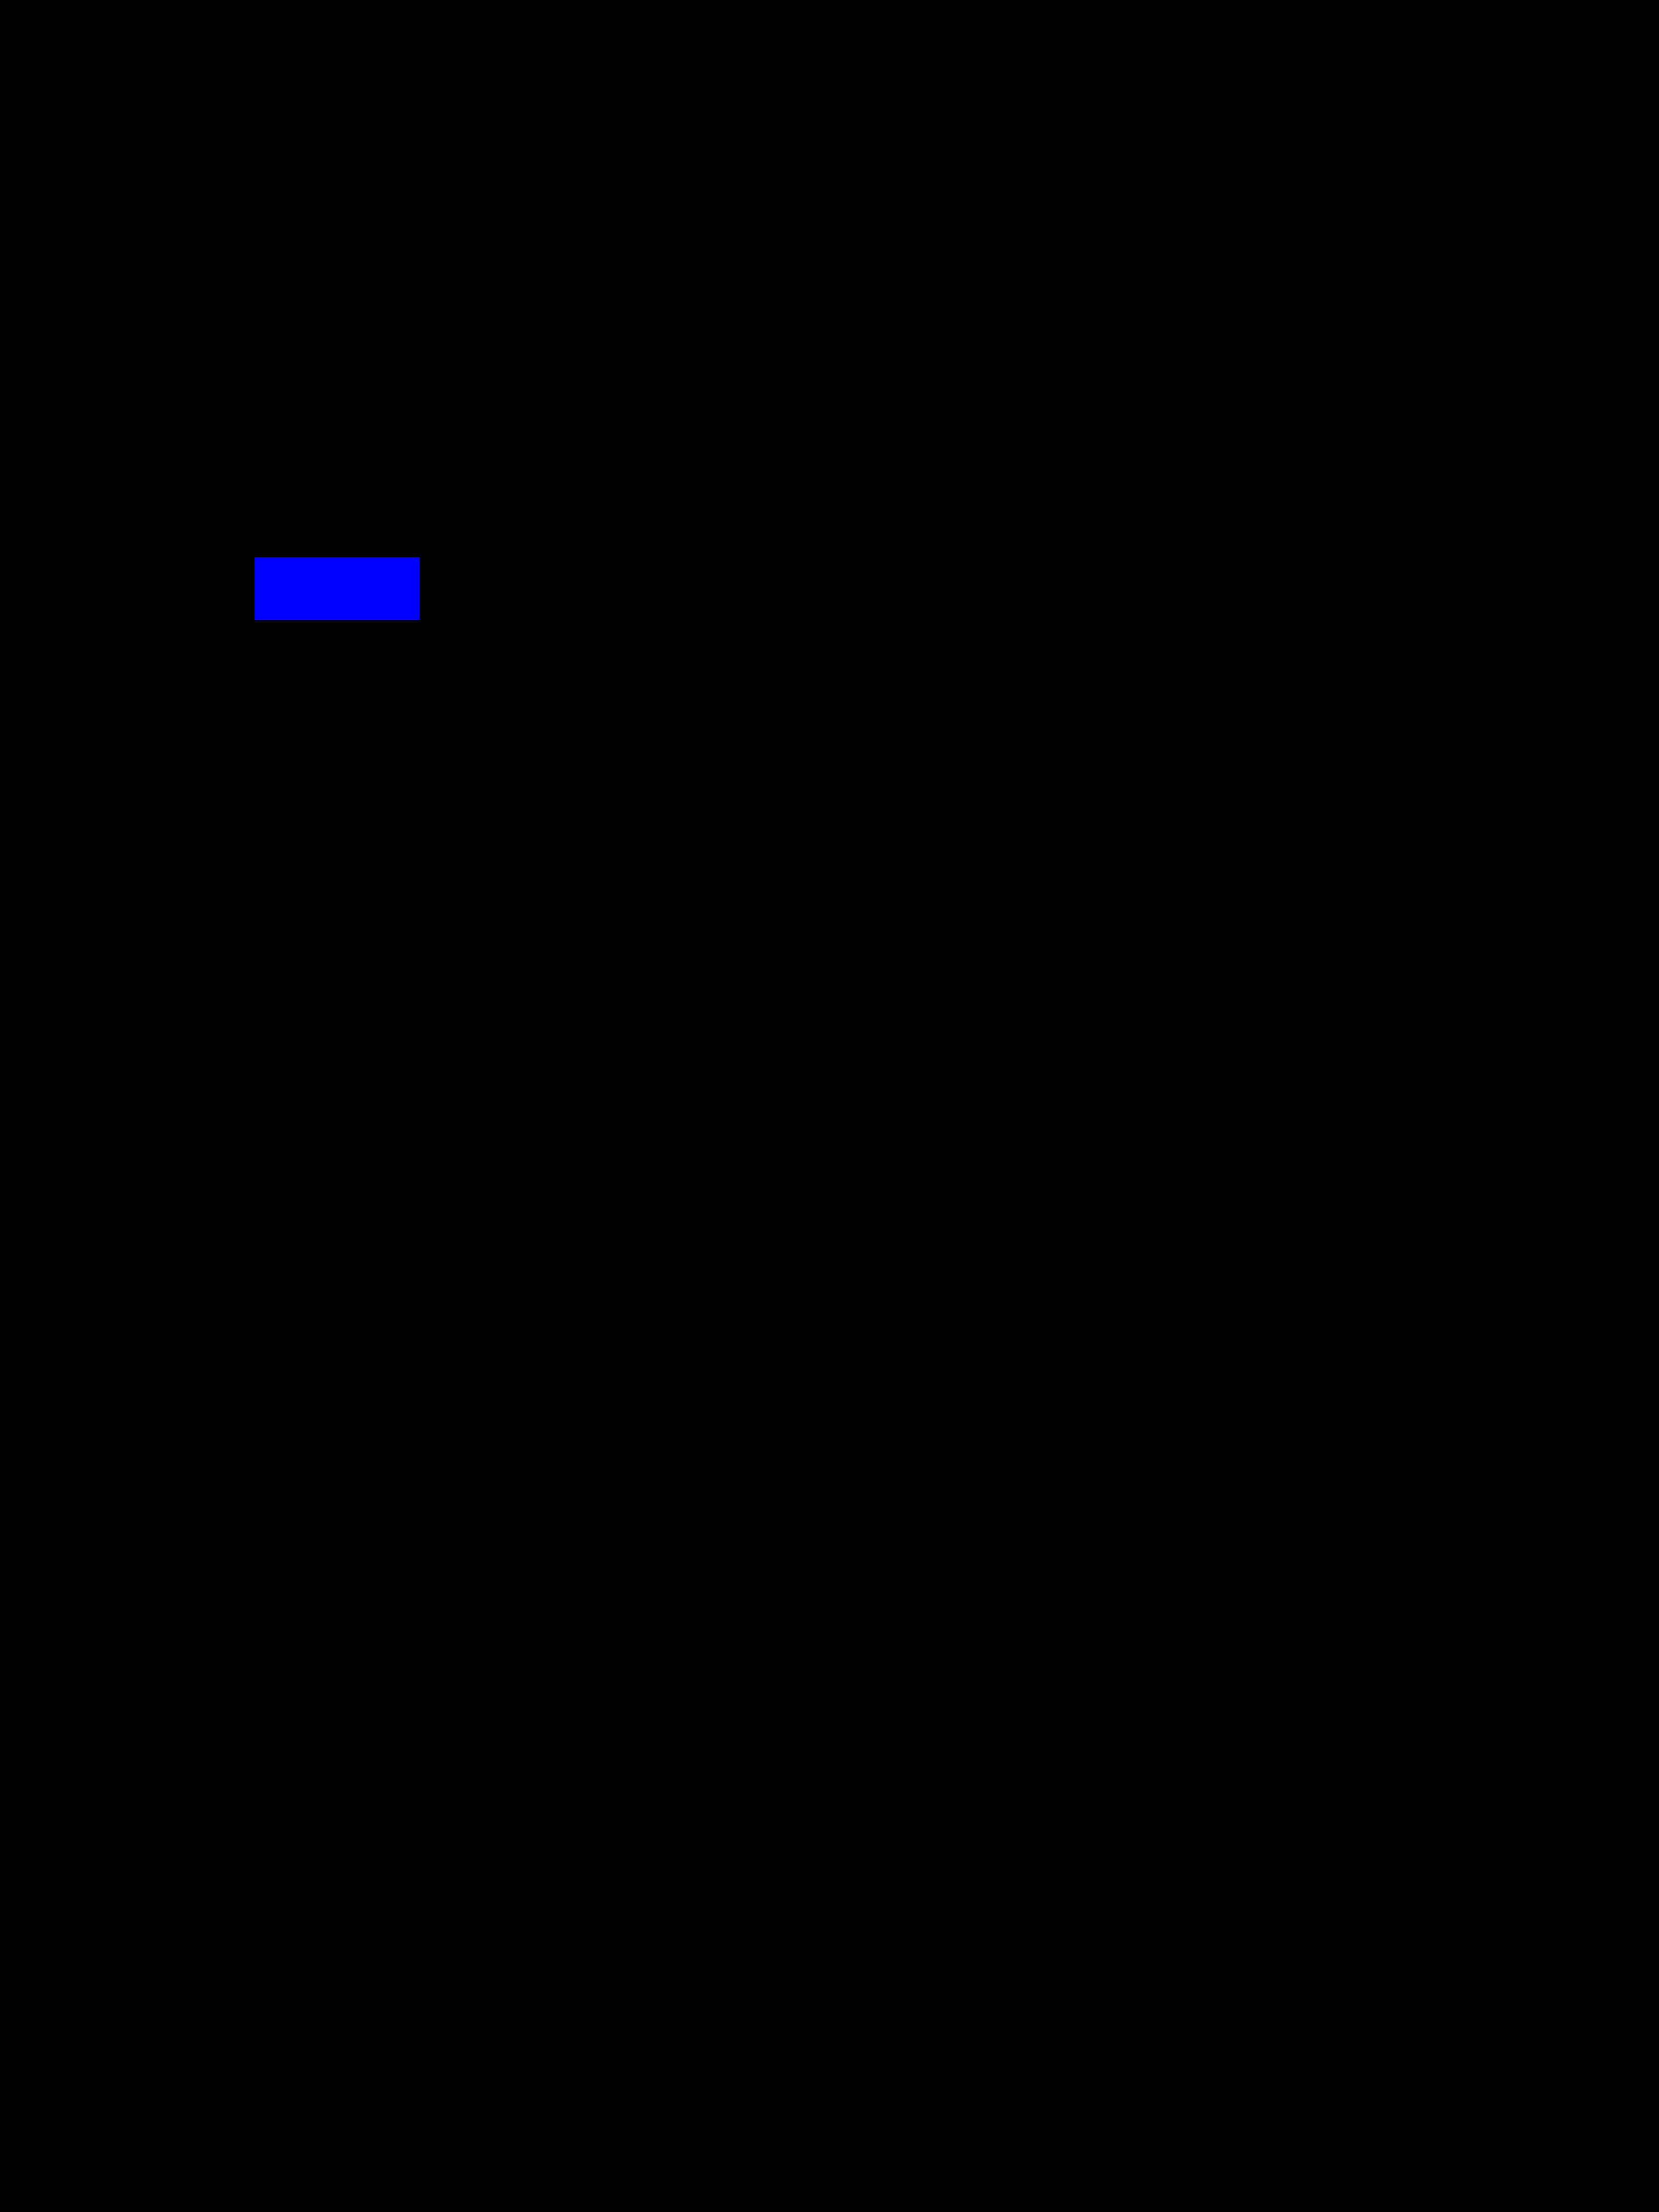

sign board


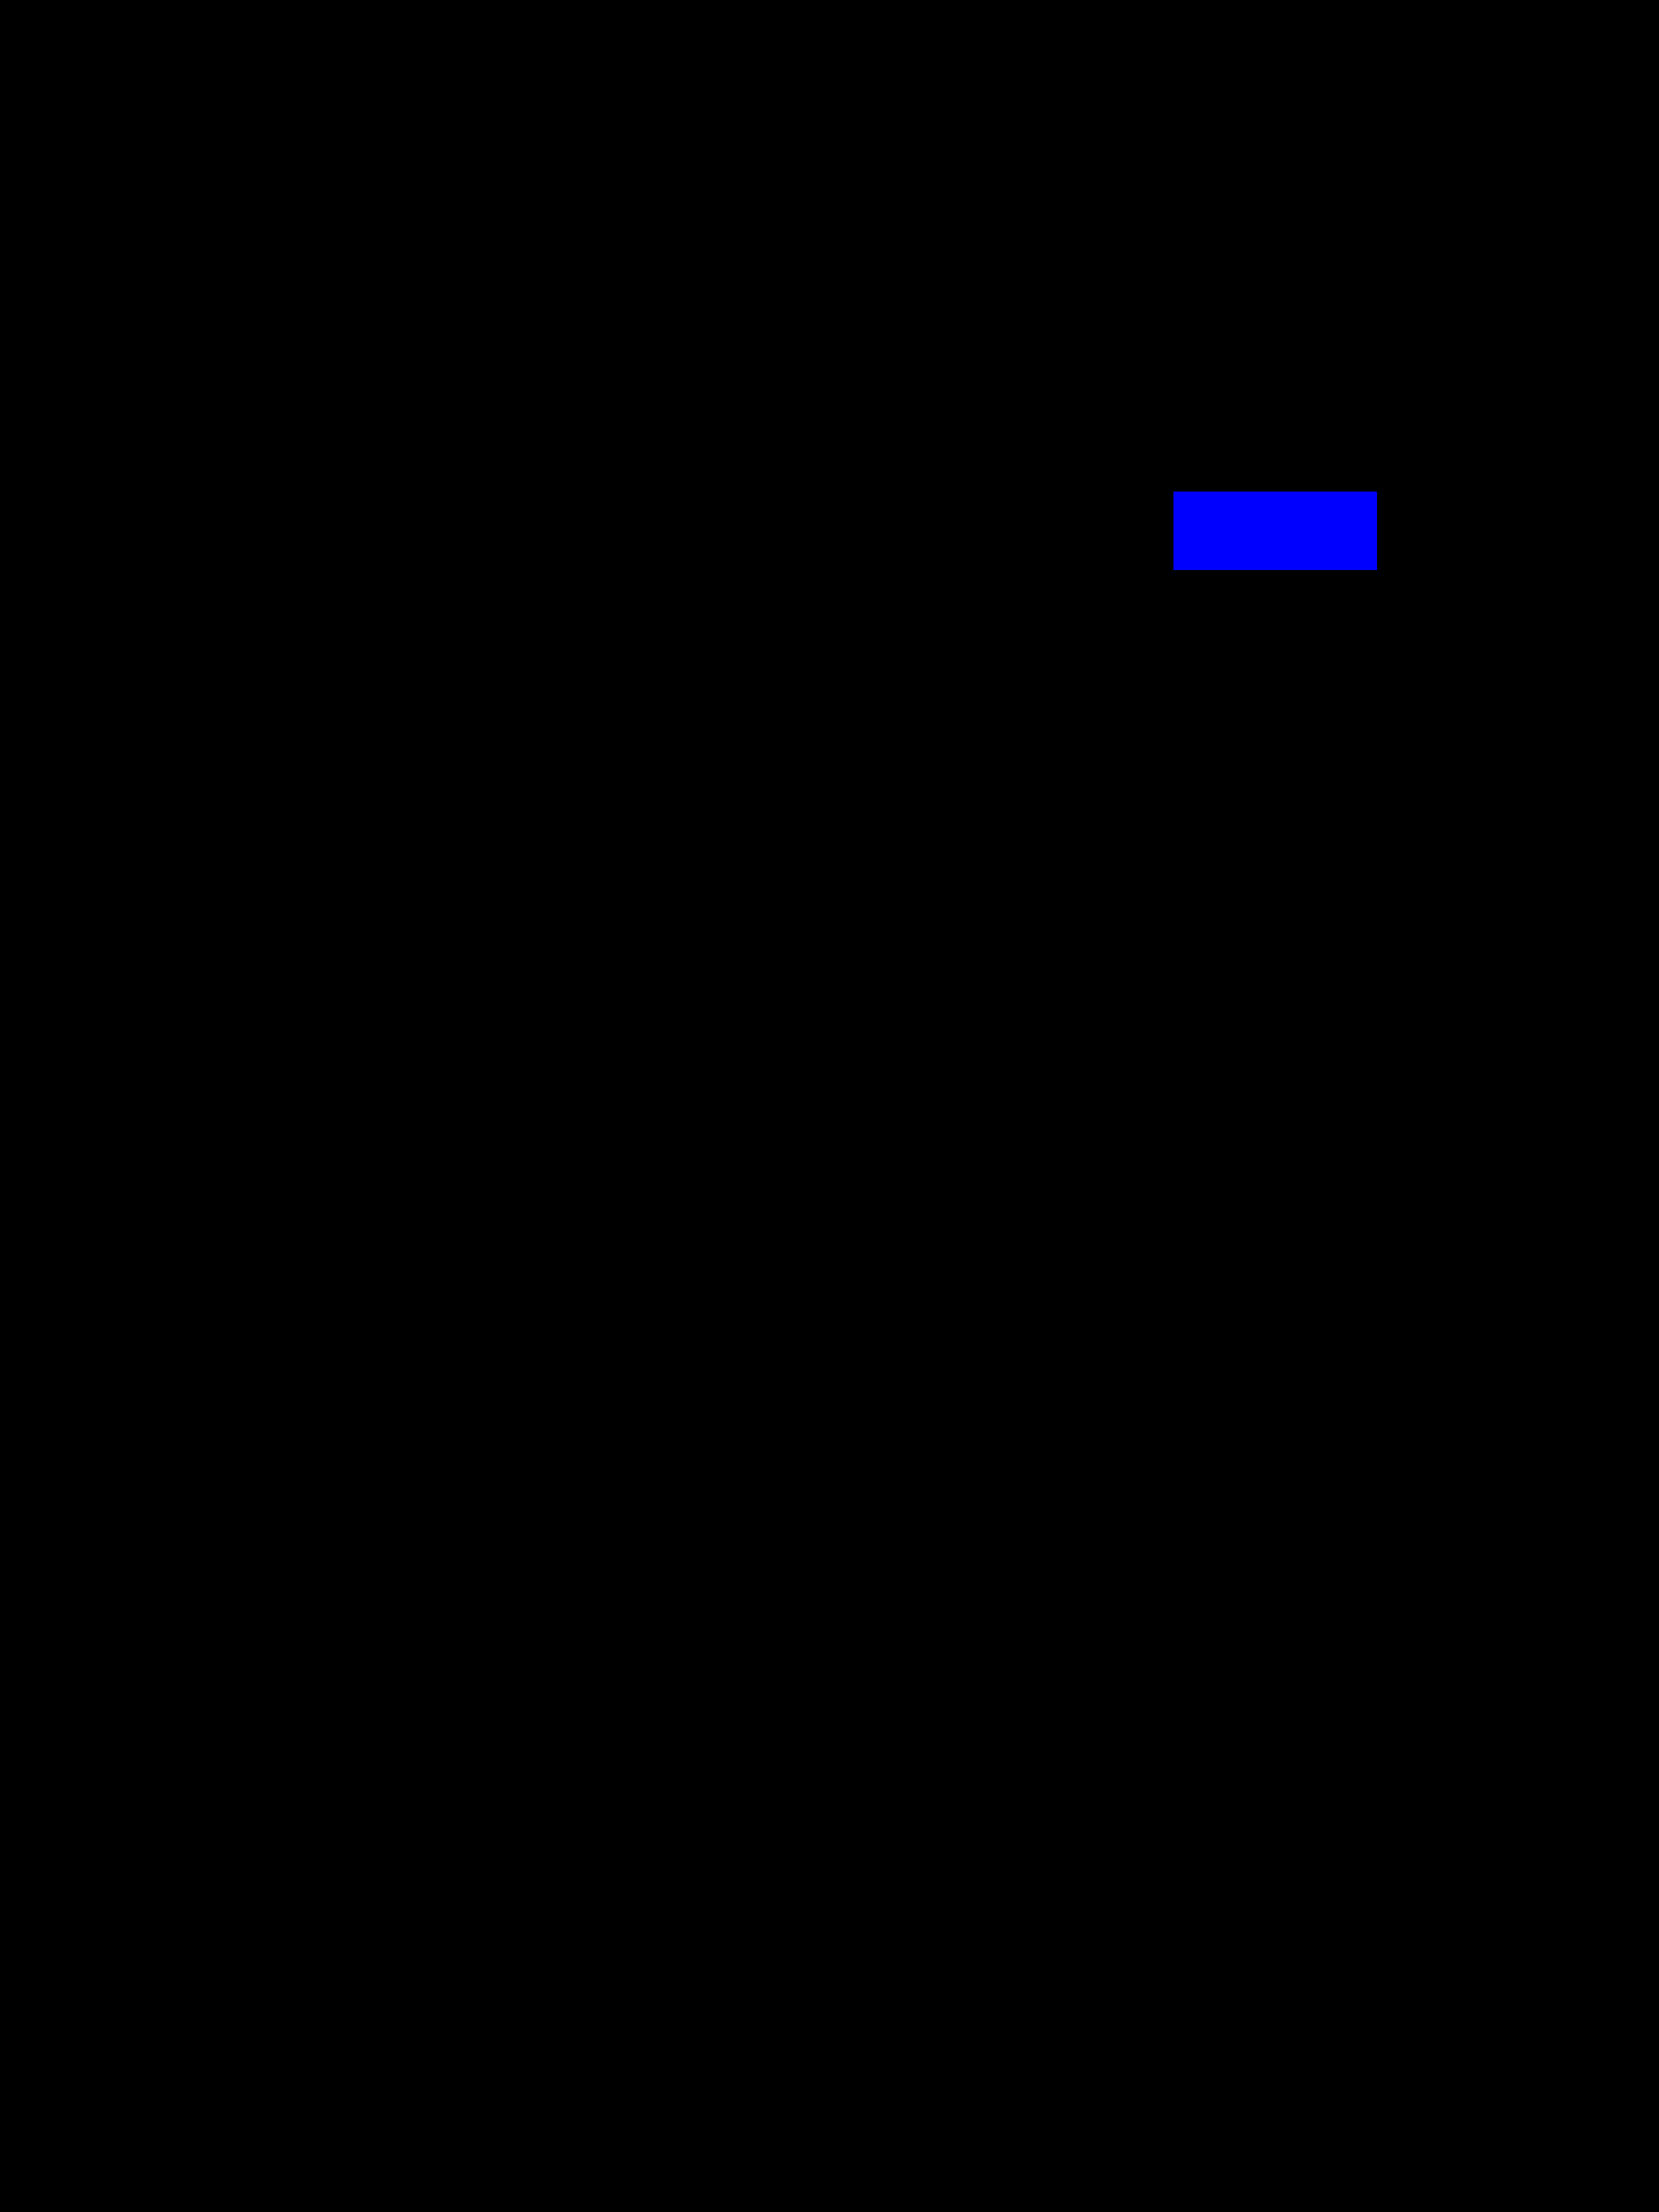

sign board


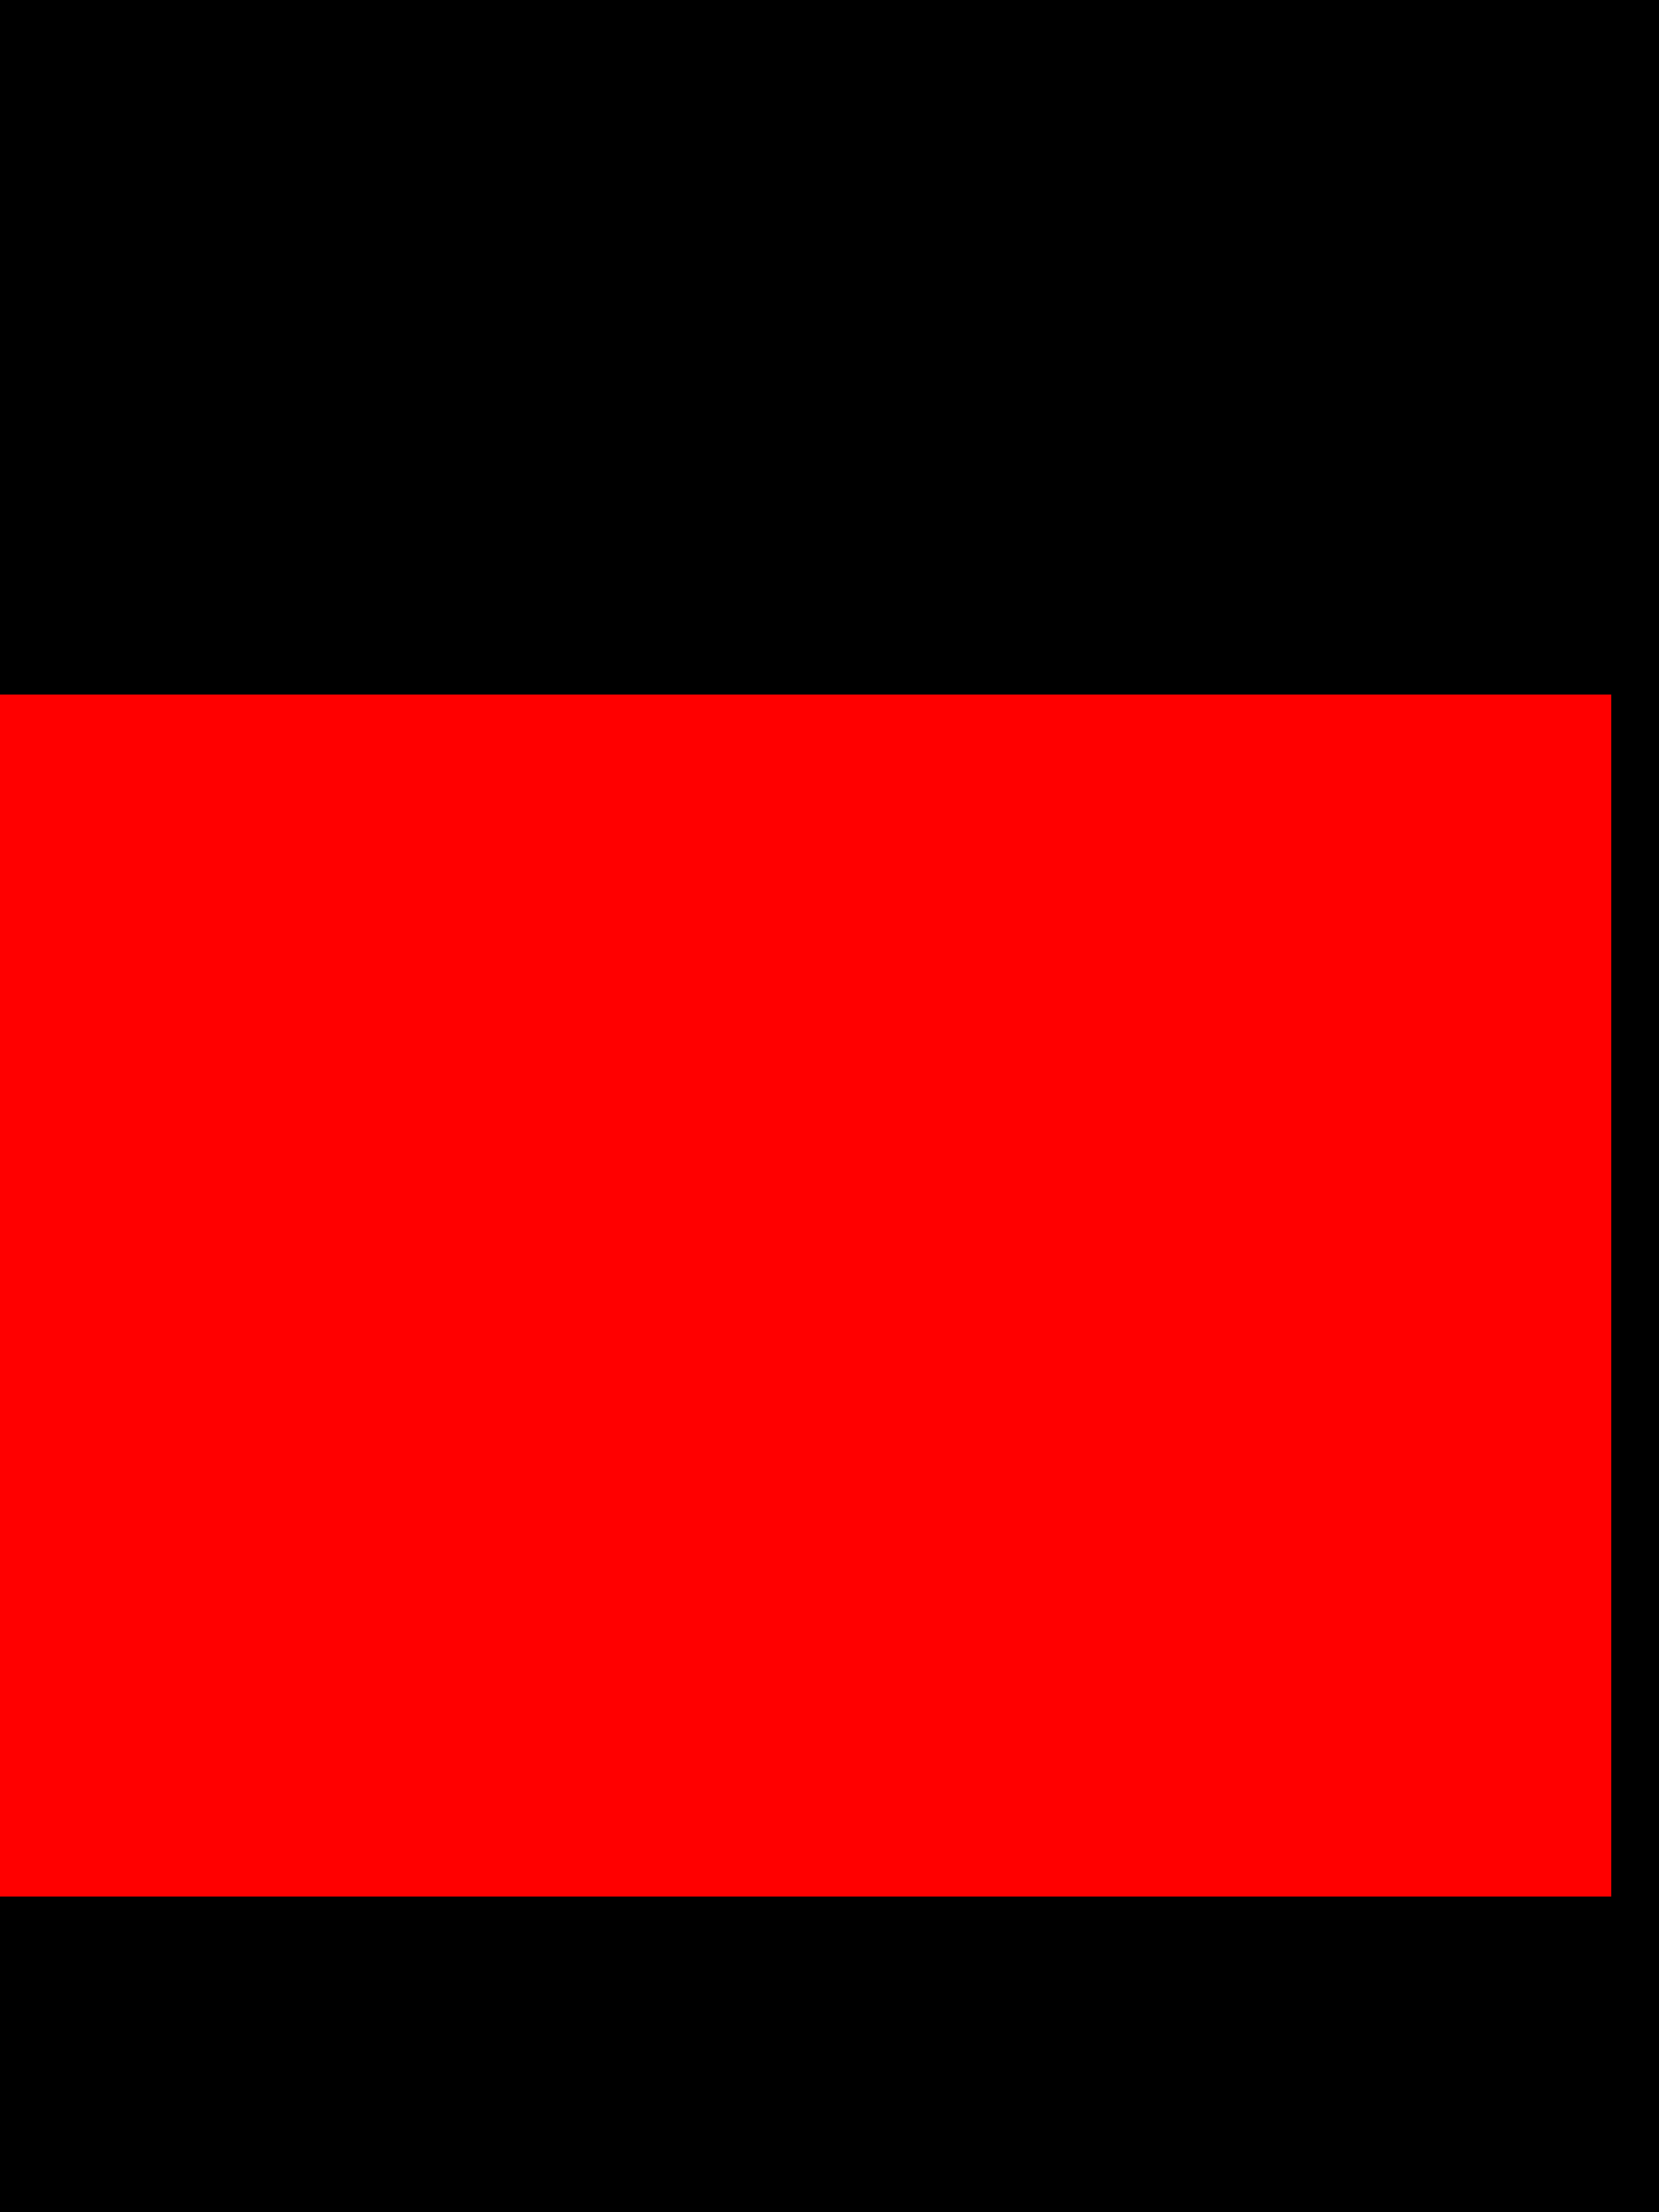

car


In [ ]:

for k, v in itertools.islice(masked_images.items(),int(len(train_loader)/BATCH_SIZE)):
  v.show()
  print(labels[k])

In [ ]:
def show_image_batch(img_list):
    num = len(img_list)
    fig = plt.figure(figsize=(8,8))
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        ax.imshow(img_list[i].numpy().transpose([1,2,0]))

    plt.show()

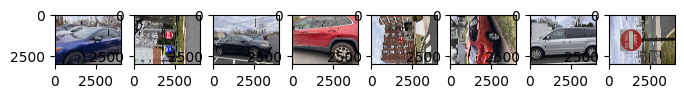

In [ ]:
show_image_batch(next(iter(train_loader)))